# Showing daily COVID-19 cases in NSW

<a href="https://colab.research.google.com/github/maxim75/data-visualization/blob/master/notebooks/COVID_data_1.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" /><br/>Open in Colab</a>

In [108]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Load case data

In [109]:
start_date = "2021-06-25"
end_date = "2021-09-30"

# Data source 
# https://data.nsw.gov.au/nsw-covid-19-data/cases
confirmed_cases_url = "https://data.nsw.gov.au/data/dataset/aefcde60-3b0c-4bc0-9af1-6fe652944ec2/resource/21304414-1ff1-4243-a5d2-f52778048b29/download/confirmed_cases_table1_location.csv"

# load data from CSV file
cases_df = pd.read_csv(confirmed_cases_url)
cases_df.notification_date = pd.to_datetime(cases_df.notification_date)

# remove last date from data since it is incomplete
cases_df = cases_df[cases_df.notification_date < cases_df.notification_date.max()]

# filter by start_date and end_date
cases_df = cases_df[(cases_df.notification_date >= start_date) & (cases_df.notification_date <= end_date)]

# Load Census 2016 population data

In [110]:
lga_population_df = pd.read_csv("https://raw.githubusercontent.com/maxim75/data-visualization/master/notebooks/data/census/lga_population.csv")
lga_population_df

,Unnamed: 0,Census_Name_2016,Tot_P_P
0,LGA10050,Albury (C),51076
1,LGA10130,Armidale Regional (A),29449
2,LGA10250,Ballina (A),41790
3,LGA10300,Balranald (A),2287
4,LGA10470,Bathurst Regional (A),41300
...,...,...,...
127,LGA18500,Woollahra (A),54240
128,LGA18710,Yass Valley (A),16142
129,LGA19399,Unincorporated NSW,1056
130,LGA19499,No usual address (NSW),12288


# Find LGAs with most number of cases

In [111]:
lga_total_cases_df = cases_df.groupby(by=["lga_name19"]).size().to_frame("case_count")\
                 .reset_index()

lga_total_cases_df = pd.merge(lga_total_cases_df, lga_population_df[["Census_Name_2016", "Tot_P_P"]], 
                              left_on="lga_name19", right_on="Census_Name_2016")[["lga_name19", "case_count", "Tot_P_P"]]

lga_total_cases_df = lga_total_cases_df.rename(columns={ "Tot_P_P": "population"})
lga_total_cases_df["cases_per_1000"] = lga_total_cases_df.case_count / lga_total_cases_df.population * 1000

lga_total_cases_df = lga_total_cases_df.sort_values("cases_per_1000", ascending=False)

lga_total_cases_df.head(10)

,lga_name19,case_count,population,cases_per_1000
15,Fairfield (C),1280,198817,6.438081
10,Canterbury-Bankstown (A),1628,346302,4.701099
14,Cumberland (A),995,216079,4.604797
29,Liverpool (C),606,204326,2.965849
45,Strathfield (A),92,40312,2.282199
3,Blacktown (C),720,336962,2.136739
38,Penrith (C),389,196066,1.984026
8,Campbelltown (C) (NSW),291,157006,1.853432
51,Waverley (A),99,66812,1.481770
16,Georges River (A),209,146841,1.423308


# Plot barchart showing LGAs with most COVID-19 cases

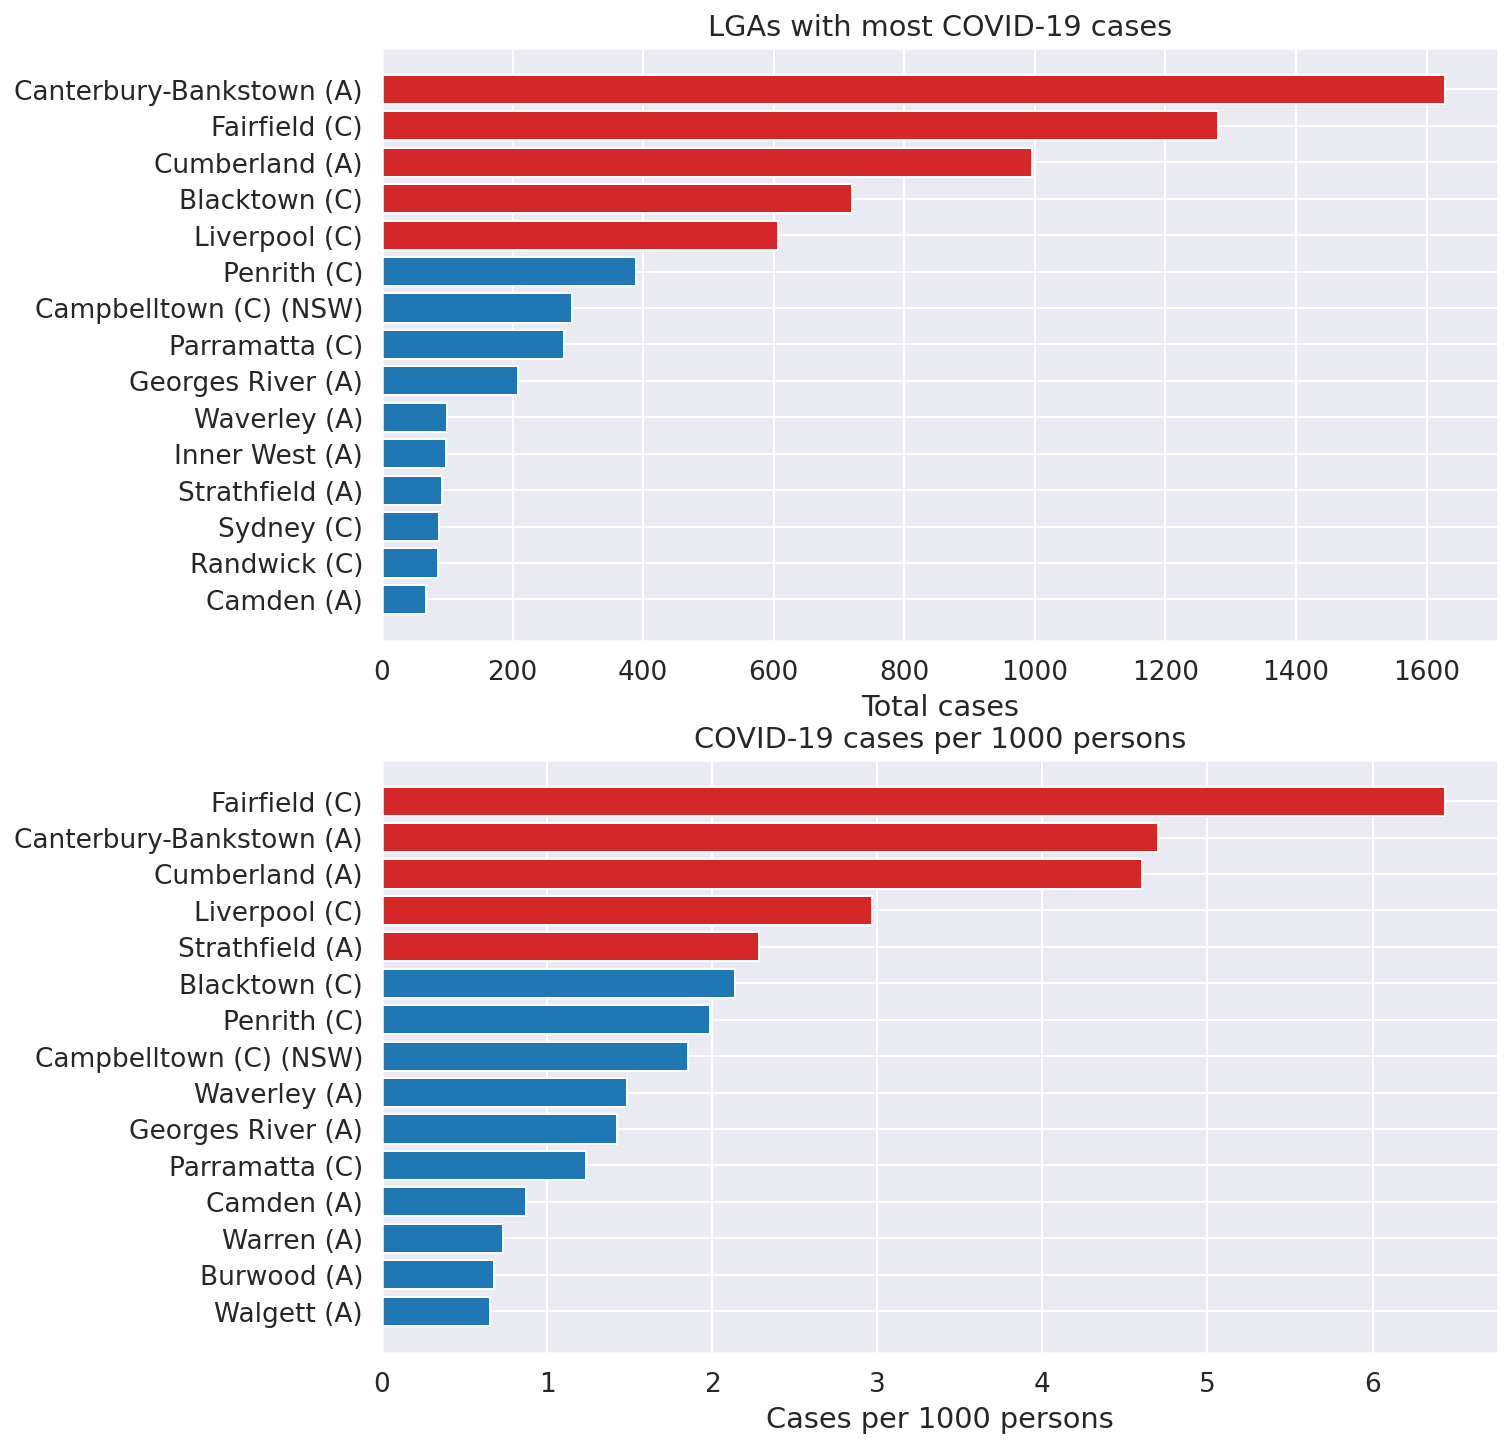

In [112]:
%config InlineBackend.figure_format = 'retina'

lga_plot_count = 15
top_lga_count = 5


fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 12))
plt.gca().invert_yaxis()
ax_total = ax[0]

ax_total.set_title("LGAs with most COVID-19 cases")
ax_total.set_xlabel("Total cases")

rects = ax_total.barh("lga_name19", "case_count",
    height=0.8,
    data=lga_total_cases_df.sort_values(by="case_count", ascending = False).head(lga_plot_count),
    color=["#d62728"]*top_lga_count + ["#1f77b4"]*(lga_plot_count-top_lga_count),
    tick_label="lga_name19"
)

ax_per_1000 = ax[1]
ax_total.invert_yaxis()

ax_per_1000.set_title("COVID-19 cases per 1000 persons")
ax_per_1000.set_xlabel("Cases per 1000 persons")

rects = ax_per_1000.barh("lga_name19", "cases_per_1000",
    height=0.8,
    data=lga_total_cases_df.head(lga_plot_count),
    color=["#d62728"]*top_lga_count + ["#1f77b4"]*(lga_plot_count-top_lga_count),
    tick_label="lga_name19"
)

# Get cases per day and 7 day mean

In [113]:
# group by notification_date and get number of records for each date
cases_per_day = cases_df.groupby(by=["notification_date"]).size().to_frame("case_count").reset_index()

# get 7 day average value
cases_per_day["7days_mean"] = cases_per_day.iloc[:,1].rolling(window=7, min_periods=7).mean()

# Plot daily cases for NSW

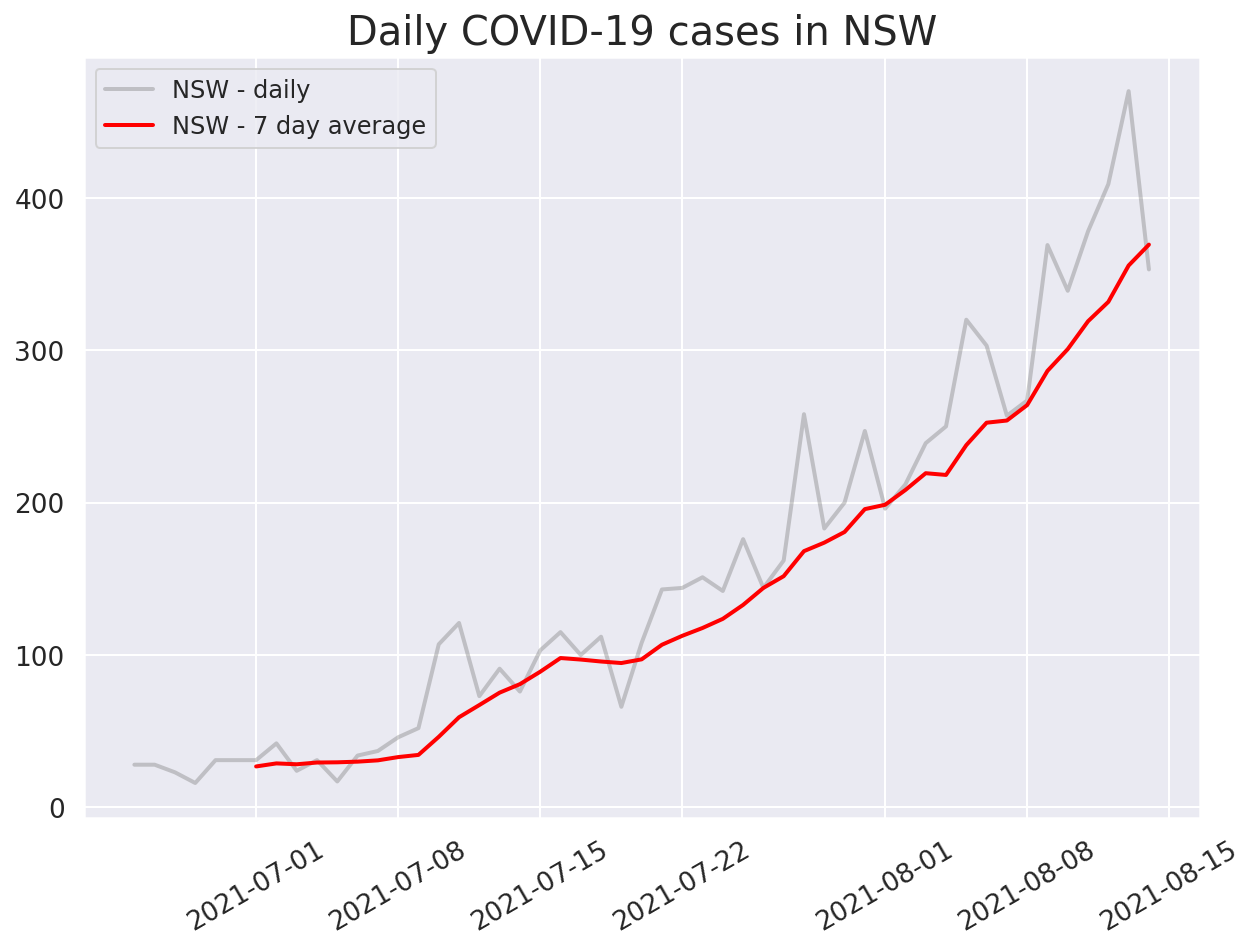

In [114]:
%config InlineBackend.figure_format = 'retina'

sns.set_theme("notebook", font_scale=1.2, rc={"lines.linewidth": 2.})

color_palette = sns.color_palette()

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot("notification_date", "case_count", data=cases_per_day, label="NSW - daily", color="grey", alpha=.4)
ax.plot("notification_date", "7days_mean", data=cases_per_day, color="red", label="NSW - 7 day average")

ax.legend(loc='upper left', bbox_to_anchor=(0, 1),fontsize=12)
ax.set_title("Daily COVID-19 cases in NSW", fontsize=20)

xticks = plt.xticks(rotation=30)

# Group by LGA and date

In [115]:
cases_per_day_per_lga = cases_df\
    .groupby(by=["lga_name19", "notification_date"])\
    .size().to_frame("count").reset_index()

# Plot daily cases charts

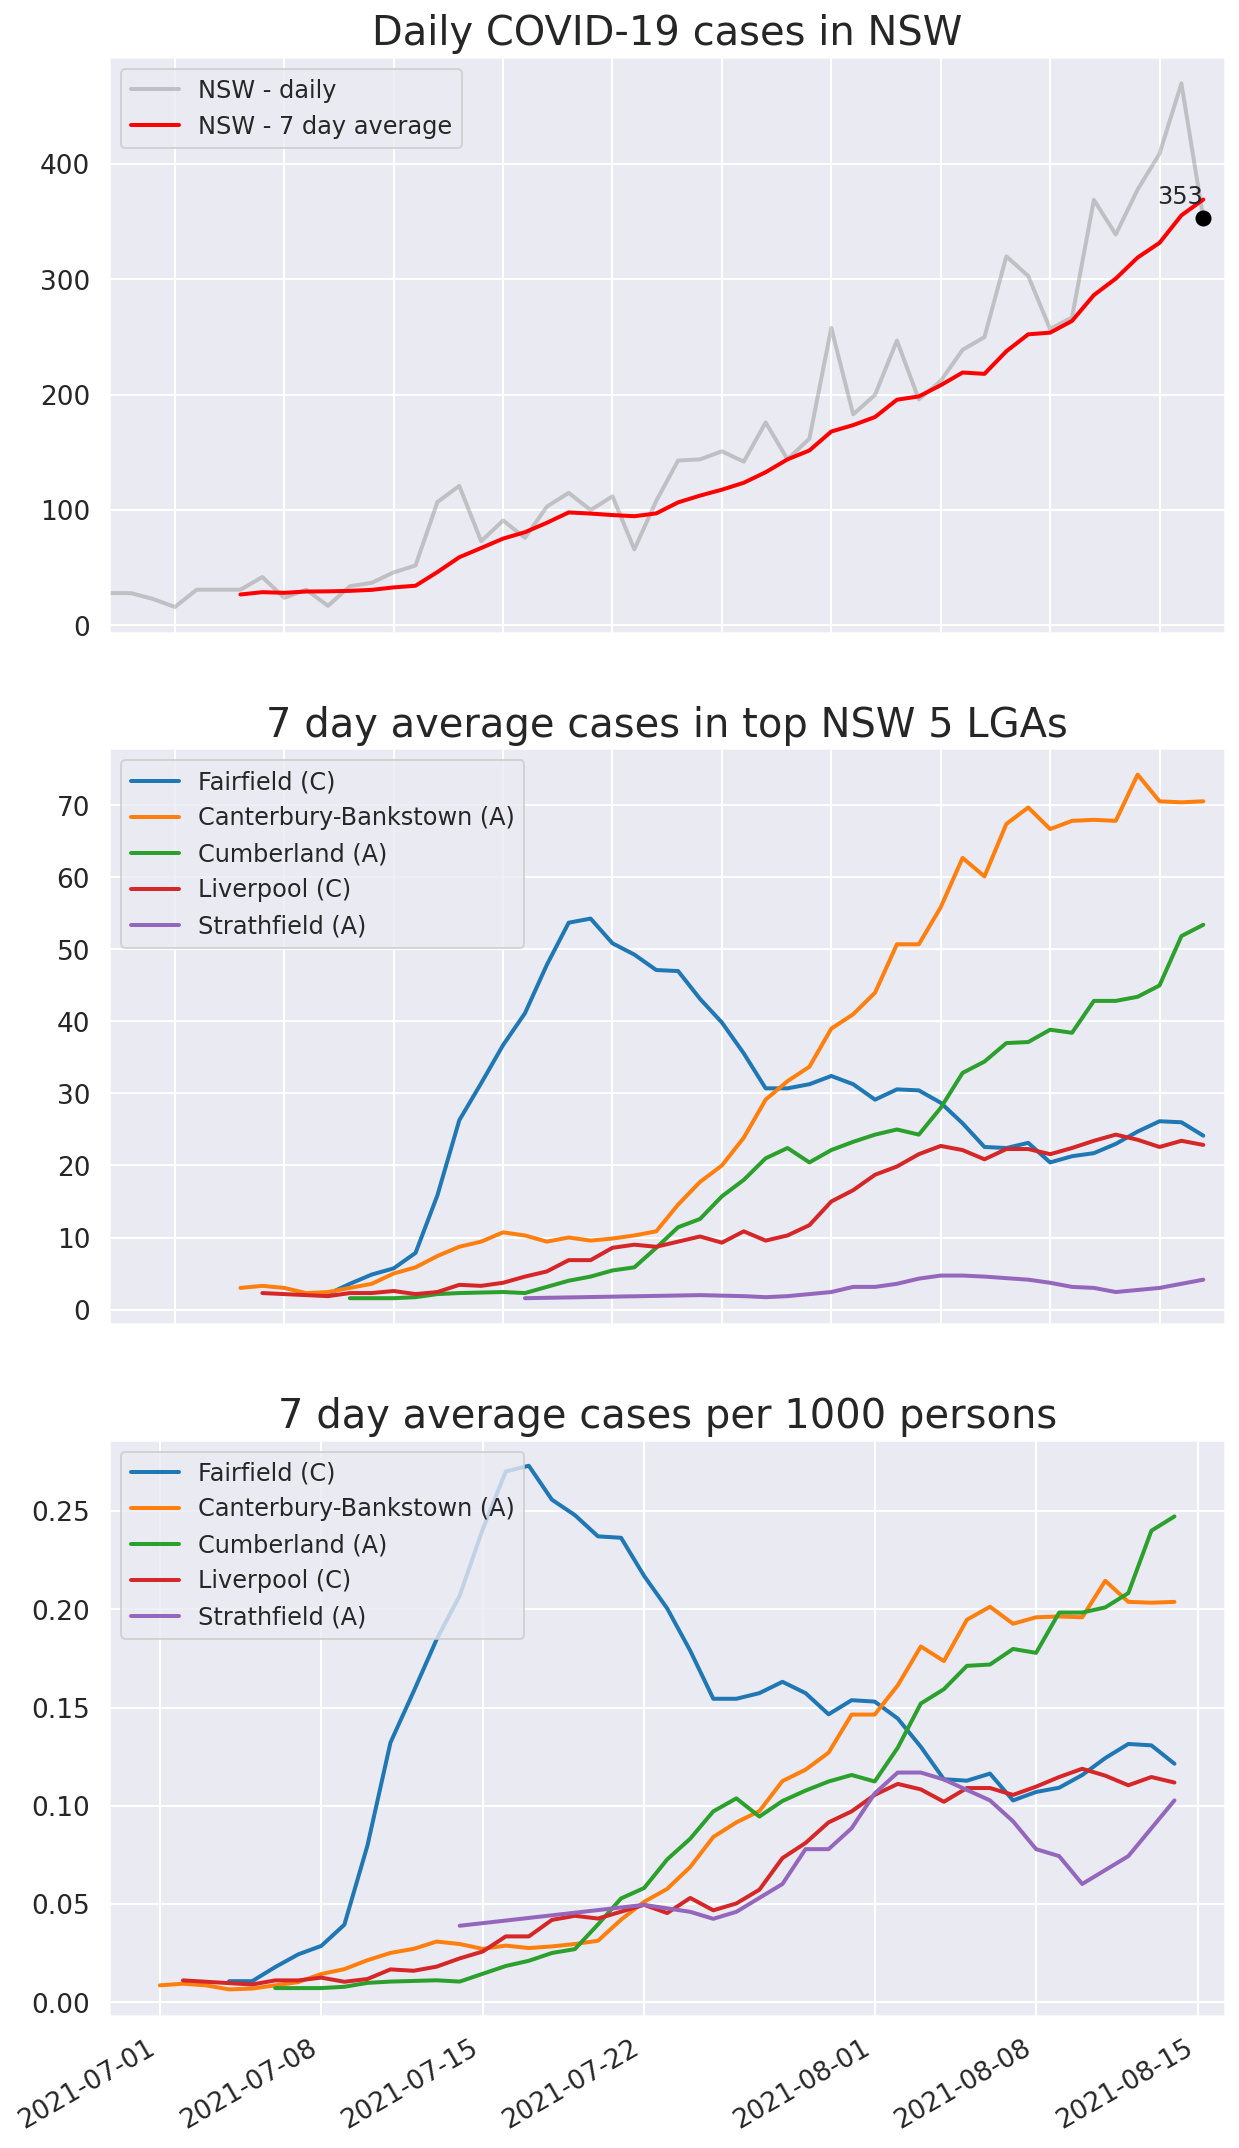

In [116]:
%config InlineBackend.figure_format = 'retina'

hightlight_date = cases_per_day.iloc[-1]

def config_datetime_axis(ax):
    date_form = mdates.DateFormatter("%-d %b %Y")
    fmt_half_year = mdates.DayLocator(interval=5)
    ax.xaxis.set_major_locator(fmt_half_year)
    ax.xaxis.set_major_formatter(date_form)
    fig.autofmt_xdate()

sns.set_theme("notebook", font_scale=1.2, rc={"lines.linewidth": 2.})

# https://github.com/d3/d3-3.x-api-reference/blob/master/Ordinal-Scales.md#categorical-colors
color_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

fig, ax = plt.subplots(figsize=(10, 20), nrows = 3, ncols = 1)

x_lim = [cases_per_day.notification_date.min(), cases_per_day.notification_date.max() + pd.DateOffset(1)]

# Plot total cases and 7 day mean graph
ax_total = ax[0]

ax_total.plot("notification_date", "case_count", data=cases_per_day, label="NSW - daily", color="grey", alpha=.4)
ax_total.plot("notification_date", "7days_mean", data=cases_per_day, color="red", label="NSW - 7 day average")

ax_total.scatter("notification_date", "case_count", data=hightlight_date, color="black", s=7**2, zorder=10, label=None)
ax_total.annotate(hightlight_date["case_count"], 
            xy=(hightlight_date["notification_date"], hightlight_date["case_count"]), 
            xytext=(0, 10), textcoords="offset pixels",
            horizontalalignment="right",
            verticalalignment="bottom",
           fontsize=12)

ax_total.legend(loc='upper left', bbox_to_anchor=(0, 1),fontsize=12)
ax_total.set_title("Daily COVID-19 cases in NSW", fontsize=20)
ax_total.set_xlim(x_lim)
config_datetime_axis(ax_total)

# Plot 7 day mean LGAs
ax_lga = ax[1]
ax_lga_per_100 = ax[2]

top_lga_names = lga_total_cases_df.head(top_lga_count).lga_name19.to_list()

for idx, lga_name in enumerate(top_lga_names):
    lga_cases = cases_per_day_per_lga[cases_per_day_per_lga.lga_name19 == lga_name].copy()
    lga_cases["mean"] = cases_per_day_per_lga[cases_per_day_per_lga.lga_name19 == lga_name].iloc[:,2].rolling(window=7, min_periods=7).mean()
    
    lga_popuation = lga_total_cases_df[lga_total_cases_df.lga_name19 == lga_name]["population"].iloc[0]

    lga_cases["per_1000"] = lga_cases["mean"]/lga_popuation*1000
    
    ax_lga.plot("notification_date", "mean", data=lga_cases,\
            color=color_palette[idx], label=lga_name)
    
    ax_lga_per_100.plot("notification_date", "per_1000", data=lga_cases,\
            color=color_palette[idx], label=lga_name)

ax_lga.set_xlim(x_lim)
    
ax_lga.legend(loc='upper left', bbox_to_anchor=(0, 1),fontsize=12)
ax_lga_per_100.legend(loc='upper left', bbox_to_anchor=(0, 1),fontsize=12)

ax_lga.set_title(f"7 day average cases in top NSW {len(top_lga_names)} LGAs", fontsize=20)
ax_lga_per_100.set_title(f"7 day average cases per 1000 persons", fontsize=20)

# set x-axis date values output and positioning
config_datetime_axis(ax_lga)
xticks = plt.xticks(rotation=30)

## 